In [20]:
import pandas as pd
import numpy as np
import os
from IPython.display import Image, display

## Order pipeline

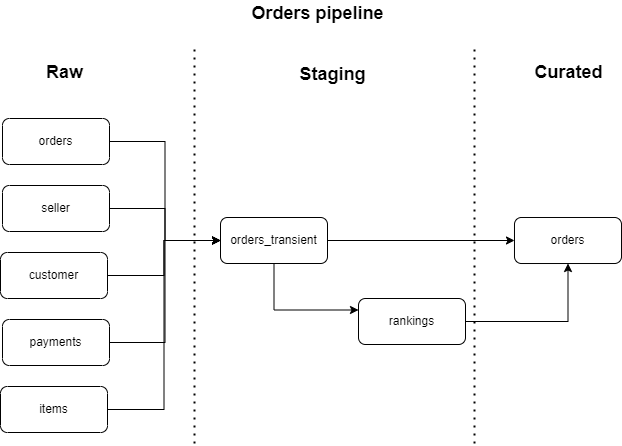

In [21]:
Image(filename="../static/orders-pipeline.png")

# Paths

In [22]:
DATA_ROOT = "..\\data\\raw"
DATA_TRANSIENT = "..\\data\\staging"

# Load Data

In [23]:
def add_root(file, root):
    """
    Apend root to path
    """
    return os.path.join(root,file)

# Remove order with more than one seller

In [24]:
def get_orders_with_multiple_seller(items):
    """
    Return a dataframe with the orders that contains multiple sellers
    """
    return  (
                items
                .groupby("order_id", as_index=False)
                .agg(
                    n_seller = ('seller_id', 'nunique')
                )
                .query("n_seller > 1")
            )

In [25]:
def remove_order_with_multiple_seller(orders, items):
    """
    Return the orders datasets without orders with multiple sellers
    """  
    orders_with_multiple_sellers = get_orders_with_multiple_seller(items)

    return (
            orders
            .merge(orders_with_multiple_sellers, on='order_id', how='left', indicator=True)
            .query("_merge == 'left_only'")
            .drop(columns=['n_seller', '_merge'])
        )

# Aggregate order_status from 8 to 4

In [26]:
def change_order_statuses(df_):

    status_map = {
        "delivered": "delivered",
        "shipped": "shipped",
        "canceled":"cancelled",
        "unavailable":"cancelled",
        "invoiced":"waiting for shipping",
        "created":"waiting for shipping",
        "processing":"waiting for shipping",
        "approved":"waiting for shipping"
    }

    df_.loc[:, "order_status"] = df_.order_status.map(status_map)

    return df_


# Prepare payment information

Aggregate by order_id and payment_type, count the number of installments, payments and sum the total payment value. Pivot(stack) the payment_type into the columns

In [27]:
def flatten_columns(df_):
    """
    Flatten hierarchical columns of a dataframe by joining them with "_"
    """
    new_columns = ["_".join(cs) for cs in df_.columns.to_flat_index()]
    df_.columns = new_columns
    return df_

def select_payment_cols(df_):
    """
    Select columns to be present in the curated orders. Installments only makes sense with credit card 
    so we will remove the other columns with installments.
    """
    installment_credit = ["number_of_installments_credit_card"]
    all_columms_no_installments = [x for x in df_.columns if "installments" not in x]
    return df_[all_columms_no_installments + installment_credit]

def fillna_payment(df_):
    """
    Fill NA values with zero except the number_of_installments_credit_card. 
    It should be null when there's no credit card payment
    """
    fill_values_except_installments ={x:0 for x in df_.columns if "installments" not in x}
    return (
        df_
        .fillna(value=fill_values_except_installments)
    )

def aggregate_payment_data(df_):
    """
    Aggregate by order_id and payment type. Pass the payment type to the columns
    """
    return (
        df_
        .groupby(["order_id", "payment_type"])
        .agg(
        payment_total = ("payment_value", "sum"),
        number_of_payments = ("payment_sequential", "max"),
        number_of_installments = ("payment_installments", "max")
        )
        .unstack()
    )

def add_total_payment(df_):
    """
    Return the total payment amount for an order_id
    """
    payment_col = (
        df_
        .filter(like="payment_total", axis="columns")
        .assign(
            payment_total_sum = lambda df: df.sum(axis=1)   
        )
        ["payment_total_sum"]
    )

    df_.loc[:, "payment_total_sum"] = payment_col
    return df_

def choose_main_payment_type(df_):
    """
    Return what is the type method that contributes the most to the payment total sum
    """
    main_type = (
                    df_
                    .filter(like="payment_total", axis="columns")
                    .div(df_.payment_total_sum, axis=0)
                    .drop(columns=["payment_total_sum"])
                    .idxmax(axis=1)
                    .str
                    .replace("payment_total_", "")
                )

    df_.loc[:, "main_payment_type"] = main_type

    return df_

# Prepare items information

In [28]:
def aggregate_items_data(items):
    return (items
            .groupby(["order_id", "seller_id"], as_index=False)
            .agg(
                total_price = ("price", "sum"),
                total_freight = ("freight_value", "sum"),
                n_items = ("order_item_id", "max")
            )
    )    


def add_gross_order_value(df_):
    df_.loc[:, "gross_order_value"] = df_.total_price + df_.total_freight
    return df_


# Join payment and items to orders

In [29]:
def join_orders_staging_with_other(orders, other, other_name):
    return (
        orders
        .merge(other, on="order_id", how="left", indicator=True)
        .rename(columns={"_merge":f"_merge_{other_name}"})
    )

# Set payment sum and payment type of orders with delivered status but no payment

In [30]:
def fill_null_payments(df_):
    """
    For those columns with status delivered but no payment do the following:
        - set payment method as voucher
        - set the total value of the payment equal to the gross order value
        - set voucher payment equal to the gross order value
        - set number of payment in voucher equal to 1
        - Fill all other payment columns to 0
        - add a column indicating that the payment record is made up
    """
    
    mask = (df_._merge_payments == "left_only") & (df_.order_status == "delivered")
    fill_dict = {
        "main_payment_type": [mask, "voucher", df_.main_payment_type],
        "payment_total_sum": [mask, df_.gross_order_value, df_.payment_total_sum],
        "payment_total_voucher": [mask, df_.gross_order_value, df_.payment_total_voucher],
        "number_of_payments_voucher": [mask, 1, df_.number_of_payments_voucher],
        "is_payment_madeup": [mask, True, False]
    }

    for col, args in fill_dict.items():
        df_.loc[:,col] = np.where(*args)


    # Fill all other payment_total_* and number_of_payment with 0
    columns_to_fill = (
                df_
                .filter(like="payment")
                .drop(columns=["main_payment_type", "_merge_payments", "is_payment_madeup"])
                .columns
                .tolist()
                )

    df_ = pd.concat(
                        [
                            df_.drop(columns=columns_to_fill)
                            , df_[columns_to_fill].fillna(0)
                        ]
                        , axis=1
                    )
    return df_

# Change status of orders without items to cancelled

In [31]:
def change_status_orders_without_items(df_):
    """
    For those orders with no items and a status different to delivered set the status to cancelled
    """

    mask = (df_._merge_items == "left_only") & (df_.order_status != "delivered")
    df_.loc[:,"order_status"] = np.where(mask, "cancelled", df_.order_status)
    return df_

# Add residuals column

In [32]:
def add_residual_to_orders(df_, atol=0.01):
    """
    Add a column that show the difference between payment and gross order value. 
    If the difference is less than the tolerance, set it to 0.
    """
    return (
        df_
        .assign(
            residual_stg = df_.gross_order_value - df_.payment_total_sum,
            residual = lambda df: np.where(np.abs(df.residual_stg <= atol), 0, df.residual_stg)
            )
        .drop(columns=["residual_stg"])
    )

# Add customer and merchant location

In [33]:
def join_orders_with_seller_and_customer(df, customer, seller):
    return (
                df
                .merge(customer, on="customer_id", how="left")
                .merge(seller, on="seller_id", how="left")
            )

# Final Cleanup

In [34]:
def final_clean_up(df_):

    """
    
    """
    #
    FINAL_COLUMNS = {
        "order_id": "object"
        , "seller_id" : "object"
        , "customer_unique_id" : "object"
        , "order_status": "object"
        , "order_purchase_timestamp" : "object"
        , "order_approved_at": "object"
        , "order_delivered_carrier_date" : "object"
        , "order_delivered_customer_date" : "object"
        , "order_estimated_delivery_date" : "object"
        , "main_payment_type" : "object"
        , "payment_total_sum" : "float64"
        , "payment_total_boleto" : "float64"
        , "payment_total_credit_card": "float64"
        , "payment_total_debit_card": "float64"
        , "payment_total_voucher": "float64"
        , "payment_total_not_defined": "float64"
        , "number_of_payments_boleto": "Int64"
        , "number_of_payments_credit_card" : "Int64"
        , "number_of_payments_debit_card" :   "Int64"
        , "number_of_payments_voucher" :  "Int64"
        , "number_of_payments_not_defined" :  "Int64"
        , "number_of_installments_credit_card" :  "Int64"
        , "gross_order_value" : "float64"
        , "total_price" : "float64"
        , "total_freight" : "float64"
        , "n_items" :  "Int64"
        , "customer_zip_code_prefix" : "Int64"
        , "customer_city" : "object"
        , "customer_state" : "object"
        , "seller_zip_code_prefix" : "Int64"
        , "seller_city": "object"
        , "seller_state" : "object"
        , "residual" : "float64"
        , "is_payment_madeup" : "bool"
    }

    df_ = df_[FINAL_COLUMNS.keys()].astype(FINAL_COLUMNS)

    #
    datetime_cols = [
        "order_purchase_timestamp", 
        "order_approved_at", 
        "order_delivered_carrier_date",
        "order_delivered_customer_date", 
        "order_estimated_delivery_date"
    ]
    for col in datetime_cols:
        df_.loc[:, col] = pd.to_datetime(df_[col])

    return  df_


# Run pipeline

In [35]:
orders =  pd.read_csv(add_root("olist_orders_dataset.csv", DATA_ROOT))

items = pd.read_csv(add_root("olist_order_items_dataset.csv", DATA_ROOT))

payments = pd.read_csv(add_root("olist_order_payments_dataset.csv", DATA_ROOT))

seller = pd.read_csv(add_root("olist_sellers_dataset.csv", DATA_ROOT))

customer = pd.read_csv(add_root("olist_customers_dataset.csv", DATA_ROOT))

In [36]:
items_staging = (
                items
                .pipe(remove_order_with_multiple_seller, items)
                .pipe(aggregate_items_data)
                .pipe(add_gross_order_value)

            )



payments_staging = (
                    payments
                    .pipe(aggregate_payment_data)
                    .pipe(flatten_columns)
                    .pipe(select_payment_cols)
                    .pipe(fillna_payment)
                    .pipe(add_total_payment)
                    .pipe(choose_main_payment_type)
                    .reset_index()
                    )




In [37]:

orders_stg = (
                orders
                .pipe(remove_order_with_multiple_seller, items)
                .pipe(change_order_statuses)
                .pipe(join_orders_staging_with_other, payments_staging, "payments")
                .pipe(join_orders_staging_with_other, items_staging, "items")
                .pipe(fill_null_payments)
                .pipe(change_status_orders_without_items)
                .pipe(add_residual_to_orders)
                .pipe(join_orders_with_seller_and_customer, customer, seller)
                .pipe(final_clean_up)
            )

In [38]:
(
    orders_stg
    .loc[orders_stg.customer_unique_id.isna()]
    .filter(like="payment")
)

,main_payment_type,payment_total_sum,payment_total_boleto,payment_total_credit_card,payment_total_debit_card,payment_total_voucher,payment_total_not_defined,number_of_payments_boleto,number_of_payments_credit_card,number_of_payments_debit_card,number_of_payments_voucher,number_of_payments_not_defined,is_payment_madeup
